In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
data = pd.read_csv("Online-Retail.csv")

In [116]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [118]:
# Preprocess the data
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
data = data.dropna(subset=['InvoiceDate'])  # Drop rows where 'InvoiceDate' couldn't be converted
data['TotalPurchase'] = data['Quantity'] * data['UnitPrice']

In [119]:
# Group data by 'CustomerID' and aggregate relevant information for clustering
customer_data = data.groupby('CustomerID').agg(
    TotalPurchase=('TotalPurchase', 'sum'),
    PurchaseFrequency=('InvoiceNo', 'count'),
    FirstPurchase=('InvoiceDate', 'min'),
    LastPurchase=('InvoiceDate', 'max')
).reset_index()

In [120]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerID         4372 non-null   float64       
 1   TotalPurchase      4372 non-null   float64       
 2   PurchaseFrequency  4372 non-null   int64         
 3   FirstPurchase      4372 non-null   datetime64[ns]
 4   LastPurchase       4372 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 170.9 KB


In [121]:
# Calculate recency in days
customer_data['Recency'] = (data['InvoiceDate'].max() - customer_data['LastPurchase']).dt.days

<Axes: xlabel='TotalPurchase', ylabel='Count'>

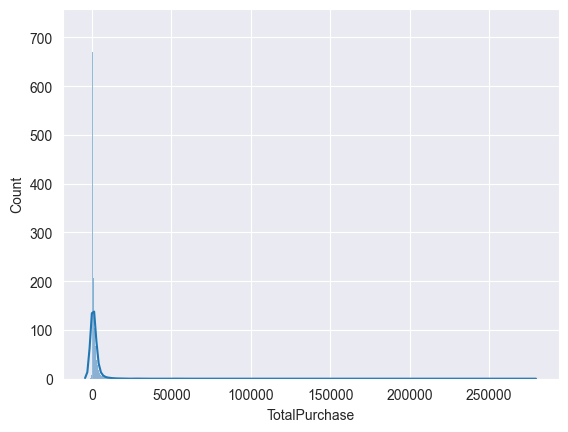

In [122]:
sns.histplot(customer_data['TotalPurchase'],kde=True)

<Axes: xlabel='PurchaseFrequency', ylabel='Count'>

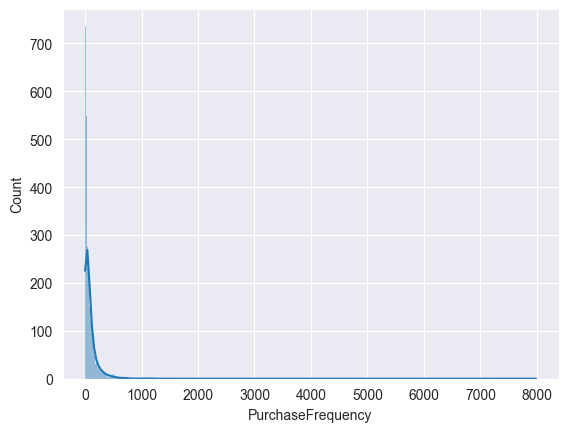

In [123]:
sns.histplot(customer_data['PurchaseFrequency'],kde=True)

In [125]:
# Replace negative or zero values with NaN to avoid invalid log calculations
customer_data['TotalPurchase'] = customer_data['TotalPurchase'].apply(lambda x: x if x > 0 else np.nan)
customer_data['PurchaseFrequency'] = customer_data['PurchaseFrequency'].apply(lambda x: x if x > 0 else np.nan)

# Drop rows with NaN values after handling negative or zero replacements
customer_data = customer_data.dropna(subset=['TotalPurchase', 'PurchaseFrequency'])

# Apply log transformation
customer_data['LogTotalPurchase'] = np.log1p(customer_data['TotalPurchase'])
customer_data['LogPurchaseFrequency'] = np.log1p(customer_data['PurchaseFrequency'])


In [127]:
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
features = customer_data[['LogTotalPurchase', 'LogPurchaseFrequency', 'Recency']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

<Axes: xlabel='Recency', ylabel='Count'>

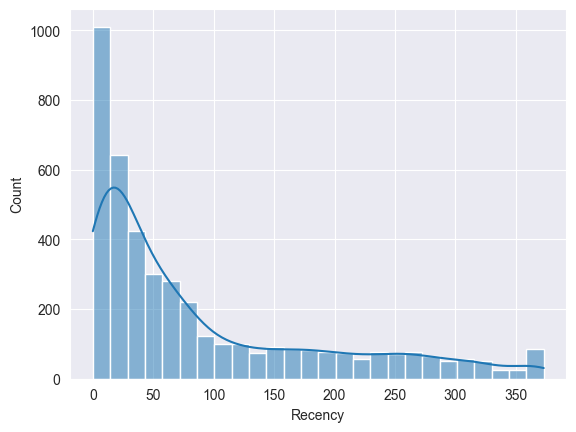

In [128]:
sns.histplot(customer_data['Recency'],kde=True)

In [129]:
from sklearn.cluster import KMeans
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++')
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

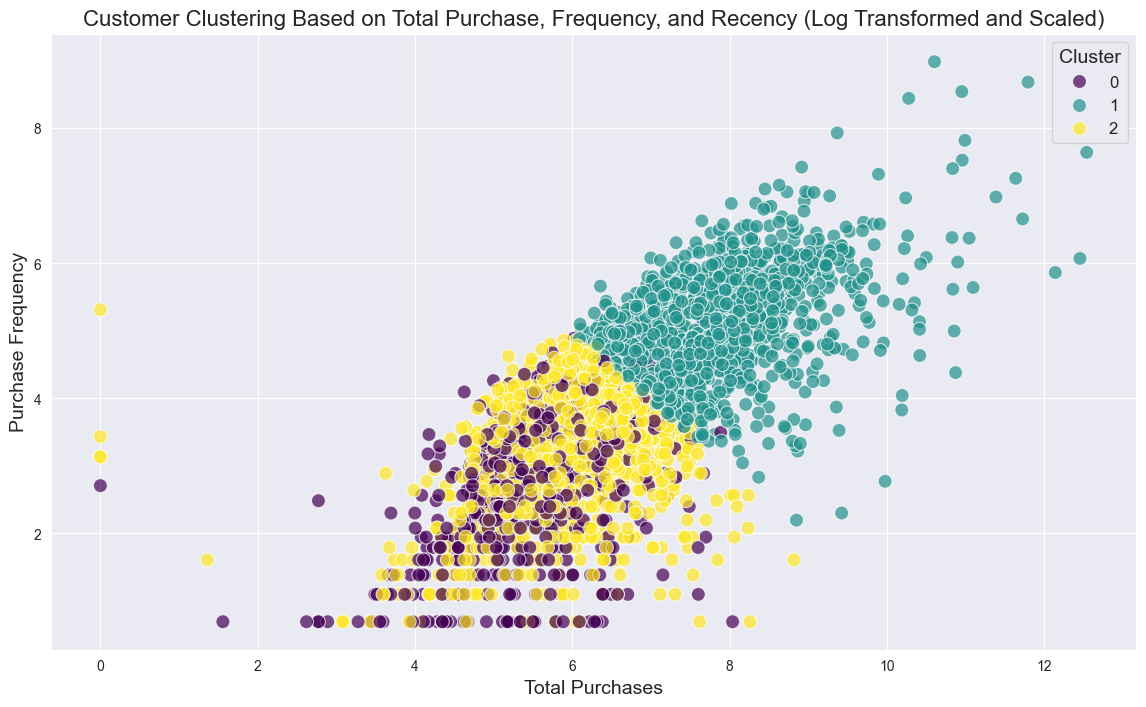

In [131]:
# Visualize the clustering result
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x=customer_data['LogTotalPurchase'], 
    y=customer_data['LogPurchaseFrequency'], 
    hue=customer_data['Cluster'], 
    palette='viridis',
    s=100,  # Set size of points for better visibility
    alpha=0.7,  # Set transparency for better overlap visualization
    legend='full'
)
plt.title('Customer Clustering Based on Total Purchase, Frequency, and Recency (Log Transformed and Scaled)', fontsize=16)
plt.xlabel('Total Purchases', fontsize=14)
plt.ylabel('Purchase Frequency', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.show()